Notebook: (https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset)

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
# import tensorflow as tf
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# from keras.models import Sequential, Model
# from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
# from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
# from keras.losses import BinaryCrossentropy
# from tensorflow.keras.applications import VGG16

# try:
#     from tensorflow.keras.optimizers import Adam
# except:
#     from keras.optimizers import Adam

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [15]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

AttributeError: module 'torch.nn' has no attribute 'optim'

In [ ]:
MAIN_DIR = "./yes"

In [ ]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [ ]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

In [ ]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [ ]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

In [ ]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)


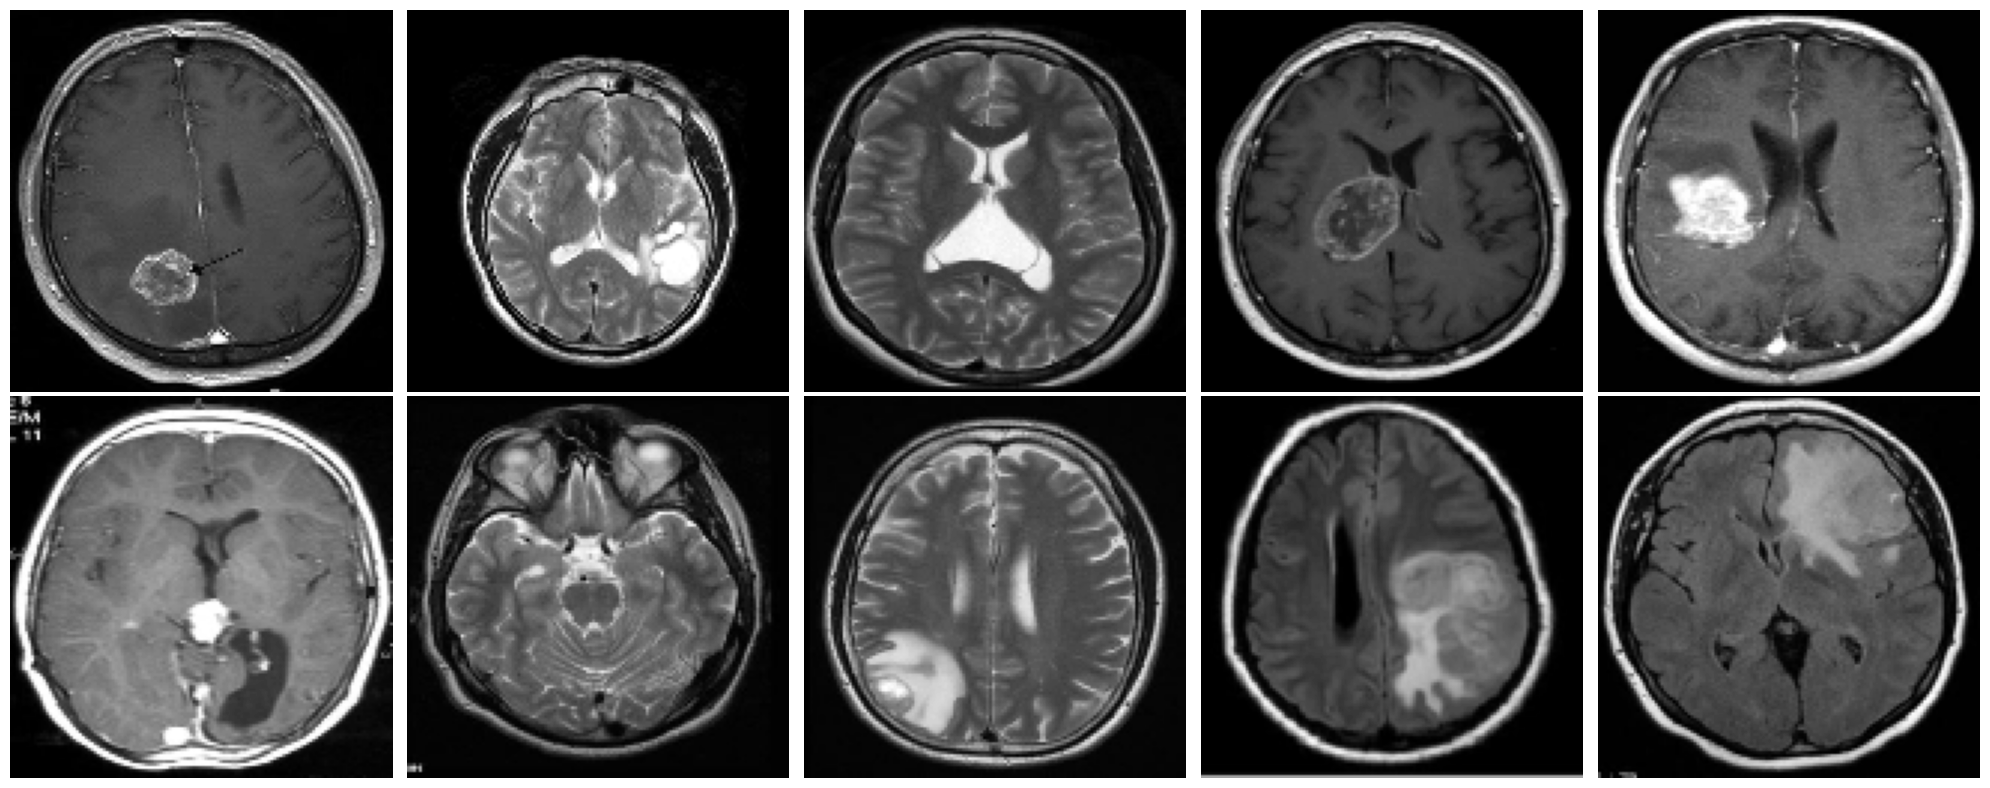

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    print(X_train[i].shape)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [ ]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [ ]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [ ]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()

NameError: name 'Sequential' is not defined

In [ ]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()